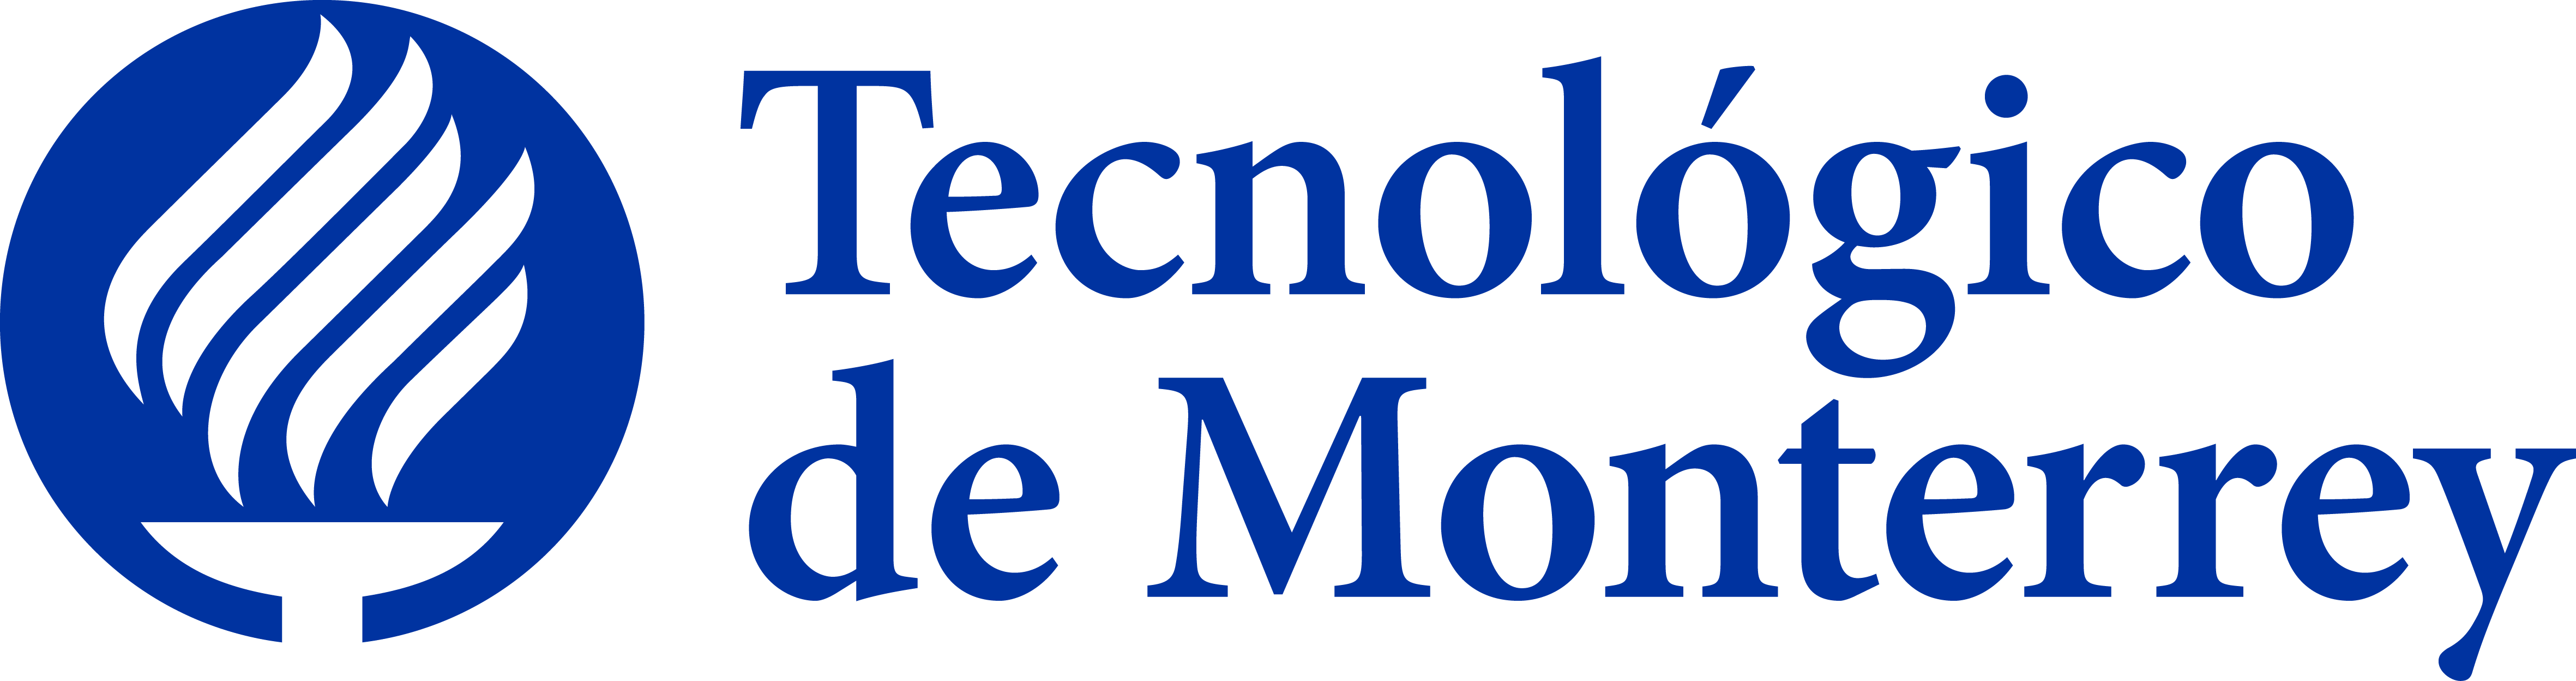

# **Master in Artificial Intelligence**

### Course: **Machine Learning Operations**

### Tecnológico de Monterrey

### Lead Dr. Gerardo Rodriguez Hernandez

## Team 33
* A01794457 Iossif Moisés Palli Laura
* A01794765 Pablo César Mecate Pantoja
* A01209133 Luis Fernando Rivera Albarrán
* A01794940 José de Jesús Peña Rodríguez
* A01795093 Miguel Angel Alpizar Flores

# Setup

In [ ]:
import pandas as pd
import os
import numpy as np
from scipy.io import arff
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Loading the data

In [ ]:
#Get route of the path
current_path = os.getcwd()
aux_curr_path = current_path
project_path = aux_curr_path.replace('/notebooks', '')
dataset_path = "dataset/CEE_DATA.arff"
dataset_path = os.path.join(project_path, dataset_path)

data, meta = arff.loadarff(dataset_path)

df = pd.DataFrame(data)
df = df.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x) #Encoding from byte to string
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666 entries, 0 to 665
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Performance           666 non-null    object
 1   Gender                666 non-null    object
 2   Caste                 666 non-null    object
 3   coaching              666 non-null    object
 4   time                  666 non-null    object
 5   Class_ten_education   666 non-null    object
 6   twelve_education      666 non-null    object
 7   medium                666 non-null    object
 8   Class_ X_Percentage   666 non-null    object
 9   Class_XII_Percentage  666 non-null    object
 10  Father_occupation     666 non-null    object
 11  Mother_occupation     666 non-null    object
dtypes: object(12)
memory usage: 62.6+ KB


            #0 : Average -  157
            #1 : Excellent - 101
            #2 : Good - 210
            #3 : Very Good - 198

# Preprocessing and Feature Engineering

In [ ]:
updated_df=df.drop_duplicates()
updated_df

,Performance,Gender,Caste,coaching,time,Class_ten_education,twelve_education,medium,Class_ X_Percentage,Class_XII_Percentage,Father_occupation,Mother_occupation
0,Excellent,male,General,NO,ONE,SEBA,AHSEC,ENGLISH,Excellent,Excellent,DOCTOR,OTHERS
1,Excellent,male,OBC,WA,TWO,SEBA,AHSEC,OTHERS,Excellent,Excellent,SCHOOL_TEACHER,HOUSE_WIFE
2,Excellent,male,OBC,OA,TWO,OTHERS,CBSE,ENGLISH,Excellent,Excellent,BUSINESS,HOUSE_WIFE
3,Excellent,male,General,WA,ONE,SEBA,AHSEC,OTHERS,Excellent,Excellent,SCHOOL_TEACHER,SCHOOL_TEACHER
4,Excellent,male,General,OA,TWO,SEBA,CBSE,ENGLISH,Excellent,Excellent,COLLEGE_TEACHER,HOUSE_WIFE
...,...,...,...,...,...,...,...,...,...,...,...,...
660,Average,female,ST,WA,TWO,SEBA,CBSE,ENGLISH,Good,Vg,DOCTOR,SCHOOL_TEACHER
661,Average,female,ST,WA,ONE,SEBA,AHSEC,ENGLISH,Good,Vg,OTHERS,HOUSE_WIFE
662,Average,male,ST,WA,THREE,SEBA,AHSEC,ENGLISH,Vg,Good,CULTIVATOR,HOUSE_WIFE
663,Average,male,ST,WA,TWO,SEBA,CBSE,ENGLISH,Good,Vg,OTHERS,SCHOOL_TEACHER


In [ ]:
y= updated_df[['Performance']]

In [ ]:
#Create oneHot enconder object
enc_OneHot = OneHotEncoder(sparse_output=False)

#Applying OneHot
y_OneHot = enc_OneHot.fit_transform(y)

#Create Label encoder object
ord_enc=LabelEncoder()

#Applying LabelEnconder to y
y_Label=ord_enc.fit_transform(y)
y_df = pd.DataFrame(y_Label, columns=['y_coding_col'])


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Restablecer los índices de ambos DataFrames
updated_df.reset_index(drop=True, inplace=True)
y_df.reset_index(drop=True, inplace=True)

# Concatenar ambos DataFrames
updated_df = pd.concat([updated_df, y_df], axis=1)

### Definining X

In [ ]:
col_of_interest=['Gender', 'Caste', 'coaching', 'time', 'Class_ X_Percentage',
                 'Class_XII_Percentage', 'Father_occupation', 'Mother_occupation',
                 'Class_ten_education', 'twelve_education', 'medium']


X = updated_df[col_of_interest]

y = updated_df[["y_coding_col"]]

### X ---> OneHot Encoding

In [ ]:
enc_OneHot = OneHotEncoder(sparse_output=False)

col_X=col_of_interest
# Create the transformer
ct = ColumnTransformer(
    transformers=[
        ("OneHotInXColumns", enc_OneHot, col_X)
    ],
    remainder='passthrough'  # keep other columns as is
)

# Applying OneHot to X
X_transformed = ct.fit_transform(X)



smote= SMOTE(sampling_strategy="minority")
X_sm, y_sm =  smote.fit_resample(X_transformed,y)

### y ---> OneHot and Label Enconding

In [ ]:
#Applying OneHot
y_OneHot = enc_OneHot.fit_transform(y_sm)

#Get Label enconder
y_Label = y_sm

-------

# Splitting the dataset

In [ ]:
#Split the dataset for y_OneHot
X_train, X_test, y_train_OneHot, y_test_OneHot = train_test_split(X_sm, y_OneHot, test_size=0.2, random_state=42)

#Split the dataset for y_Label (Pandas Series)
X_train, X_test, y_train_Label, y_test_Label = train_test_split(X_sm, y_Label, test_size=0.2, random_state=42)

In [ ]:

Experiments = [
    (
        "Random Forest SMOTE",
        RandomForestClassifier(class_weight="balanced"),
        (X_train, y_train_OneHot),
        (X_test, y_test_OneHot)
    ),

    (
        "XGBoost SMOTE",
        XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        (X_train, y_train_OneHot),
        (X_test, y_test_OneHot)
    ),

    (
         "Logistic Regression SMOTE",
        LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200),
        (X_train, y_train_Label),
        (X_test, y_test_Label)
    ),

     (
        "K-Nearest Neighbors SMOTE",
        KNeighborsClassifier(n_neighbors=5),
        (X_train, y_train_Label),
        (X_test, y_test_Label)
    ),

    (
        "MLP SMOTE",
        MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, activation='relu', solver='adam'),
        (X_train, y_train_OneHot),
        (X_test, y_test_OneHot)
    ),

    (
        "Support Vector Classifier SMOTE",
        SVC(kernel='linear', probability=True),
        (X_train, y_train_Label),
        (X_test, y_test_Label)
    )


]


In [ ]:
results_per_model = []

for model_name, model, train_set, test_set in Experiments:
    X_train = train_set[0] #get Xtrain from the list models
    y_train = train_set[1] #get y_train from list models
    X_test = test_set[0]    #get x_test from list models
    y_test = test_set[1]   #get y_test from list models

    model.fit(X_train, y_train)  #train the current model
    y_pred = model.predict(X_test) #make predictions
    report = classification_report(y_test, y_pred, output_dict=True) #make a dict of the classification report


    results_per_model.append(report) #add the previus dict to a list

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:35:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passe

In [ ]:
mlflow.set_experiment("Analysis Model Smote")
mlflow.set_tracking_uri("http://3.84.228.208:5000")

for i, element in enumerate(Experiments):
    model_name = element[0]
    model = element[1]
    report = results_per_model[i]

    with mlflow.start_run(run_name=model_name):
            mlflow.log_param("model", model_name)


            # -------------Class interpretation----------------
            #0 : Average
            #1 : Excellent
            #2 : Good
            #3 : Very Good

            #Metrics of class 0

            mlflow.log_metric('acurracy_class_0', report['0']['precision'])
            mlflow.log_metric('recall_class_0', report['0']['recall'])
            mlflow.log_metric('f1_class_0', report['0']['f1-score'])

            #Metrics of class 1

            mlflow.log_metric('acurracy_class_1', report['1']['precision'])
            mlflow.log_metric('recall_class_1', report['1']['recall'])
            mlflow.log_metric('f1_class_1', report['1']['f1-score'])

            #Metrics of class 2

            mlflow.log_metric('acurracy_class_2', report['2']['precision'])
            mlflow.log_metric('recall_class_2', report['2']['recall'])
            mlflow.log_metric('f1_class_2', report['2']['f1-score'])

            #Metrics of class 3

            mlflow.log_metric('acurracy_class_3', report['3']['precision'])
            mlflow.log_metric('recall_class_3', report['3']['recall'])
            mlflow.log_metric('f1_class_3', report['3']['f1-score'])


            if "XGB" in model_name:
                mlflow.xgboost.log_model(model, "model")
            else:
                mlflow.sklearn.log_model(model, "model")



2024/10/25 18:35:25 INFO mlflow.tracking.fluent: Experiment with name 'Analysis Model Jesus2' does not exist. Creating a new experiment.
2024/10/25 18:35:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/25 18:35:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run Random Forest SMOTE at: http://3.84.228.208:5000/#/experiments/232098787916050303/runs/6bfdd7a9759d478590d9818af44f644e.
2024/10/25 18:35:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://3.84.228.208:5000/#/experiments/232098787916050303.
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:35:54] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarn